In [1]:
%matplotlib notebook

## Importing from the Power_Extraction notebook
# (see https://ipynb.readthedocs.io/en/latest/)
from ipynb.fs.defs.Power_Extraction import load_experiment_powers, EXPERIMENTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Retrieve saved powers
Loads the power values for each experiment in pandas dataframe format 

In [2]:
fpga = load_experiment_powers('fpga')
tofino = load_experiment_powers('tofino')
cpu = load_experiment_powers('cpu')

## Assign roles
Define the roles for each of the devices so they can be properly labeled

In [3]:
from collections import OrderedDict

# The functions performed by each device
DEVICE_ROLES = OrderedDict([
    ('tclust4', 'memcached'),
    ('tclust2', 'iperf server'),
    ('tofino', 'Switching/HC'),
    ('fpga12/0', 'KV-store'),
    ('fpga12/1', 'Encoder'),
    ('fpga12/2', 'Decoder'),
    ('fpga13/0', 'Compress'),
    ('fpga13/1', 'Decompress')]
)

# A label for each device: the role prefixed by the device name
LABELED_DEVICES = {k : k + " : " + v for k, v in DEVICE_ROLES.items()}

# In the case of CPU experiments, the roles are different
CPU_DEVICE_ROLES = dict(
    tclust4='decompressor',
    tclust2='compressor',
    tofino='switching',
)

# Table of experiment powers
The following cells produce a table showing the average increase in power during an expereiment

Power increases are calculated relative to a baseline taken as 15 seconds prior to experiment start

In [4]:
def order_exps(df):
    ''' If the output is a MultiIndex'd dataframe, places the index in the order that exps were run '''
    newidx = pd.MultiIndex.from_product([df.index.levels[0], ['baseline', 'hc', 'drop', 'fec', 'kv']])
    return df.reindex(newidx)

def calc_exp_increase(powers):
    ''' Calculates the increase in power consumption during each experiment '''
    # Get only the powers for devices we care about
    powers = powers[powers.device.isin(LABELED_DEVICES.keys())]
    
    # Calculate the baseline prior to the experiment
    pre = powers[powers.exp_time < 0] 
    pre_mean = pre.groupby([ 'device','experiment', 'trial'], sort=False)['power'].mean()
    
    # Power during the middle of the experiment (20 - 45 seconds)
    dur = powers[(powers.exp_time > 20) & (powers.exp_time < 45)]
    dur_mean = dur.groupby([ 'device', 'experiment','trial'], sort=False)['power'].mean()
    
    # Increase in power
    diff = dur_mean - pre_mean
    # Average across trials
    diff = diff.groupby(level=[0,1]).mean() 
    # Add the device-role labels to the index
    diff = diff.rename(index = LABELED_DEVICES, level=0)
    
    return order_exps(diff)

def compare_increases(fpga, tofino):
    ''' Compares the increases in power of each device between FPGA and Tofino Header Compression'''
    f_inc = calc_exp_increase(fpga).rename('FPGA HC')
    t_inc = calc_exp_increase(tofino).rename("Tofino HC")
    comparison = (f_inc / t_inc).rename('FPGA/Tofino')
    return pd.concat([f_inc, t_inc, comparison], axis=1).round(3)

In [5]:
comparison = compare_increases(fpga, tofino)
comparison

FPGA HC  Tofino HC  FPGA/Tofino
fpga12/0 : KV-store    baseline    0.002      0.011        0.151
                       hc          0.009      0.010        0.838
                       drop        0.008      0.006        1.358
                       fec         0.006      0.009        0.643
                       kv          0.010      0.006        1.559
fpga12/1 : Encoder     baseline   -0.001      0.008       -0.156
                       hc          0.005      0.006        0.905
                       drop        0.006      0.002        2.291
                       fec         0.458      0.463        0.991
                       kv          0.467      0.463        1.010
fpga12/2 : Decoder     baseline    0.006     -0.002       -2.558
                       hc          0.001      0.008        0.072
                       drop       -0.006      0.007       -0.796
                       fec         0.589      0.591        0.997
                       kv          0.576      0.570        1.010
fpga13/0 : Compress    baseline    0.008      0.002        3.609
                       hc          0.696      0.015       47.052
                       drop        0.205      0.000     6184.572
                       fec         0.499     -0.004     -125.105
                       kv          0.511      0.008       62.325
fpga13/1 : Decompress  baseline    0.003      0.004        0.720
                       hc          0.584      0.002      250.309
                       drop        0.167      0.001      136.337
                       fec         0.412      0.004      109.088
                       kv          0.414      0.000     1268.853
tclust2 : iperf server baseline   50.821     48.898        1.039
                       hc         52.431     49.789        1.053
                       drop       36.010     35.326        1.019
                       fec        50.919     50.924        1.000
                       kv         50.408     46.953        1.074
tclust4 : memcached    baseline   40.693     40.259        1.011
                       hc         43.400     42.489        1.021
                       drop       41.921     43.306        0.968
                       fec        41.496     41.898        0.990
                       kv         37.075     36.800        1.007
tofino : Switching/HC  baseline    0.413      0.413        1.001
                       hc          0.644      0.409        1.575
                       drop        0.327      0.179        1.831
                       fec         0.718      0.517        1.389
                       kv          0.777      0.536        1.449

# Plotting Power Consumption
The following cells produce two types of plots: 
* Matrix of Device x Experiment power consumption
* Boxplot of overall (summed) power consumption by experiment

In [6]:
# These are the times (relative to the start of the experiment)
# at which mcd and iperf traffic start running
MCD_TIME_RANGE=(0, 50)
IPERF_TIME_RANGE=(5, 45)

In [7]:
def plot_device_experiment(df_exp, smooth=None, color=None, norm=False, baseline=False, ax=None):
    ''' Plots all of the trials of a single experiment.
    Assumes that df_exp contains only one experiment and one device
    smooth  -- rolling mean over this many seconds
    norm     -- plots normalized power as a percent increase over baseline
    baseline -- plots power increase as raw wattage over baseline
    '''
    if ax is not None:
        plt.sca(ax)
    else:
        ax = plt.gca()
        
    if len(df_exp) == 0:
        return
        
    for i, df in df_exp.groupby('trial'):
        if smooth is not None:
            df = df.rolling(smooth, on='date_time')[['power', 'date_time', 'exp_time']].mean()
        df = df.reset_index(drop=True)
            
        if norm:
            base = df[df.exp_time < 0].power.mean()
            df.power = ((df.power / base) - 1) * 100
            
        if baseline is True:
            base = df[df.exp_time < 0].power.mean()
            df.power -= base
        elif baseline:
            df.power -= baseline
            

        df = df.reset_index(drop=True)
        x = plt.plot(df.exp_time, df.power, '-', color=color, linewidth=1)
        
    for t in MCD_TIME_RANGE:
        plt.axvline(t, color='k')

    for t in IPERF_TIME_RANGE:
        plt.axvline(t, color='gray')
    
    # Returns one instance of the plot to be used in the legend
    return x[0]

#### An example: power used by tofino during baseline cpu experiment vs tofino experiment


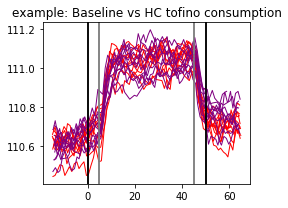

In [8]:
%matplotlib inline
plt.figure(figsize=(4,3))
plot_device_experiment(cpu[(cpu.device == 'tofino') & (cpu.experiment == 'baseline')], color='r')
plot_device_experiment(cpu[(cpu.device == 'tofino') & (cpu.experiment == 'hc')], color='purple')
plt.title('example: Baseline vs HC tofino consumption')
plt.tight_layout()

In [9]:
# The range of the y-axis for norm'd and raw power plots
# (first four characters of device name are taken as key)
NORM_RANGES = dict(
    fpga=3.25,
    tofi=3.25,
    tclu=52
)
RAW_RANGES = dict(
    fpga=2.2,
    tofi=2.2,
    tclu=60
)

def plot_power_matrix(df, device_roles=DEVICE_ROLES, experiments=EXPERIMENTS, axs=None, norm=False, baseline=False, do_label = True, **kwargs):
    ''' Produces device x experiment matrix of plots '''
    if axs is None:
        # note to self: squeeze is a useful argument - axs will always have 2 dimensions
        fig, axs = plt.subplots(len(device_roles), len(experiments) + 1, 
                                figsize=(7, 6), sharex='all', sharey='row',
                                gridspec_kw={'hspace': .2, 'wspace': .02}, squeeze=False)

    if not norm:
        ranges = RAW_RANGES
    else:
        ranges = NORM_RANGES
        
    for ax_col, dev in zip(axs, device_roles):
        df_dev = df[df.device == dev]  
        for ax, exp in zip(ax_col, experiments):
            df_exp = df_dev[df_dev.experiment == exp]
            leg_handle = plot_device_experiment(df_exp, ax=ax, norm=norm, baseline=baseline, **kwargs)
            
        if dev[:4] in ranges:
            if baseline:
                low = 0
            elif not norm:
                low = np.percentile(df_dev.power, 1) - ranges[dev[:4]] / 20.
            else:
                low = - ranges[dev[:4]] / 20.
            ax.set_ylim([low, low + ranges[dev[:4]]])

    if do_label:
        for i, (dev, role) in enumerate(device_roles.items()):
            ax = axs[i, -1]
            label = '%s\n%s' % (dev, role)
            ax.text(.1, .5, label, verticalalignment='center', transform=ax.transAxes)
            ax.axis('off')    

        for i, exp in enumerate(experiments):
            ax = axs[0, i]
            ax.set_title(exp)
    
    return axs, leg_handle


### Analysis of power consumption during CPU experiments

#####  Raw power values

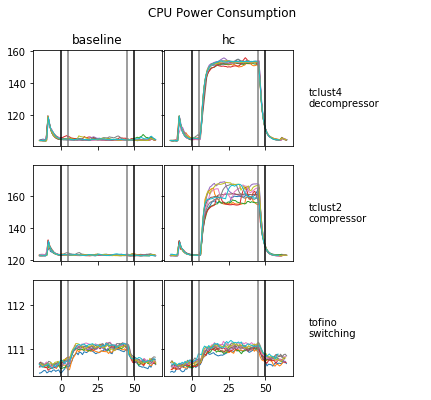

In [10]:
axs, _ = plot_power_matrix(cpu, CPU_DEVICE_ROLES, ['baseline', 'hc'])
plt.suptitle("CPU Power Consumption");

##### Comparison of tofino power

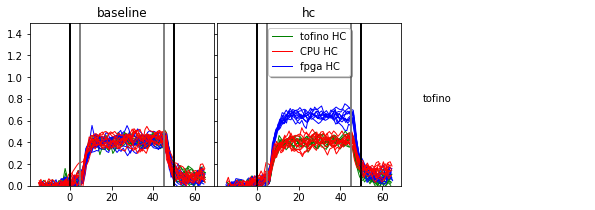

In [11]:
# plot_power_matrix automatically generates figure if no axis is passed in
fig, axs = plt.subplots(1, 3, 
                        figsize=(10, 3), sharex='all', sharey='row',
                        gridspec_kw={'hspace': .2, 'wspace': .02}, squeeze=False)
axs, t = plot_power_matrix(tofino, {'tofino': ''}, ['baseline', 'hc'], axs=axs, color='g', baseline=True, do_label=False)
axs, f = plot_power_matrix(fpga, {'tofino': ''}, ['baseline', 'hc'], axs=axs, color='b', baseline=True, do_label=False)
axs, c = plot_power_matrix(cpu, {'tofino': ''}, ['baseline', 'hc'], axs=axs, color='r', baseline=True)

axs[0][0].set_ylim([0, 1.5])
plt.legend([t, c, f], ['tofino HC', 'CPU HC', 'fpga HC'], framealpha=1, shadow=True);


## Analysis of power during FPGA and Tofino Experiments

#### Normalized Power Values (% increase over baseline)

In [12]:
def plot_compare_matrix(fpga, tofino, **kwargs):
    axs, f = plot_power_matrix(fpga, color='b', do_label=False, **kwargs)
    _, t = plot_power_matrix(tofino, axs=axs, color='g', **kwargs)
    plt.figlegend([t, f], ['Tofino HC', 'FPGA HC'], ncol=2, shadow=True, loc='upper center')

#### Raw power values

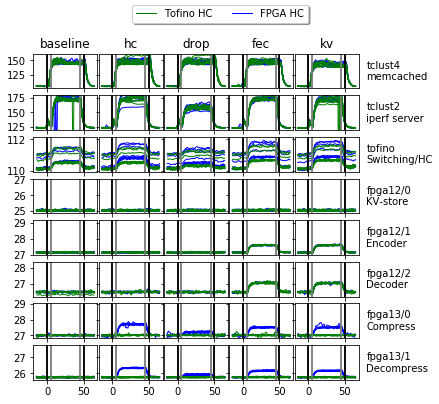

In [13]:
plot_compare_matrix(fpga, tofino)
plt.suptitle("Raw Power Values");

#### Normalized power values

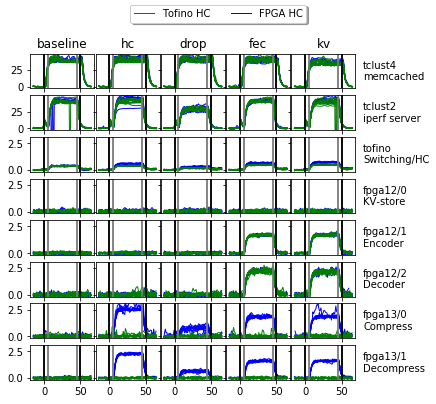

In [14]:
plot_compare_matrix(fpga, tofino, norm=True)
plt.suptitle("Normalized Power Values");

## Summed utilization by experiment
Experiment utilization can be broken down in various ways

###### The following are maps of experiments onto the devices that are used during them

In [15]:

EXP_DEVS = {
    'baseline': ['tofino'],
    'hc': ['tofino', 'fpga13/0', 'fpga13/1'],
    'drop': ['tofino', 'fpga13/0', 'fpga13/1'],
    'fec': ['tofino', 'fpga13/0', 'fpga13/1', 'fpga12/1', 'fpga12/2'],
    'kv': ['tofino', 'fpga13/0', 'fpga13/1', 'fpga12/1', 'fpga12/2', 'fpga12/0'],
}

def fpga_devs(exp_devs=EXP_DEVS):
    return exp_devs

def tofino_devs(exp_devs = EXP_DEVS):
    return {k : list(filter(lambda x: not x.startswith('fpga13'), v)) for k, v in exp_devs.items()}

def all_devs(exp_devs = EXP_DEVS):
    return {k : exp_devs['kv'] for k in exp_devs}

def remove_tofino(exp_devs=EXP_DEVS):
    return {k : list(filter(lambda x: x != 'tofino', v)) for k, v in exp_devs.items()}

##### Plotting device by experiment

In [16]:
def remove_baseline(df):
    ''' Subtracts the pre-experiment baseline power '''
    dfs = []
    for x, a in df.groupby(['device', 'experiment', 'trial'], as_index=False):
        # Restting indices makes things a lot faster sometimes for some reason
        a = a.reset_index(drop=True)
        a.power -= a[a.exp_time < 0].power.mean()
        dfs.append(a)
    return pd.concat(dfs, ignore_index=True)

def dev_exp_power(df, devices, experiments=EXPERIMENTS, sub_baseline=False, remove_tofino=False):
    powers = []
    if sub_baseline:
        df = remove_baseline(df)
    for exp in experiments:
        df_exp = df[df.experiment == exp]
        df_dev = df_exp[df_exp.device.isin(devices[exp])]
        if len(df_dev) == 0:
            powers.append([])
            continue
        
        mid = df_dev[(df_dev.exp_time >= 20) & (df_dev.exp_time <= 45)]
        mid = mid.assign(rexp_time = mid.exp_time.round())
        mid = pd.DataFrame(mid.groupby(['trial', 'device', 'rexp_time'])['power'].mean())
        grouped = mid.groupby(['rexp_time', 'trial'])
        summed = grouped.sum()
        num_present = grouped.power.count()
        summed = summed[num_present == max(num_present)]
        if remove_tofino:
            if remove_tofino is True:
                summed.power -= tofino_increase(df_dev, False)
            else:
                summed.power -= remove_tofino
        powers.append(summed.power)
    
    return powers
    
    
def plot_dev_exp_power(df, devices, experiments=EXPERIMENTS ,color=None, **kwargs):
    powers = dev_exp_power(df, devices, experiments, **kwargs)
    means = [np.mean(p) if len(p) else 0 for p in powers]
    
    plt.plot(range(1, len(powers)+1), means, '.-', color=color, alpha=.5)
    handle = plt.boxplot(powers, labels=experiments, 
                       boxprops = dict(facecolor=color, alpha=.7), 
                       flierprops=dict(markeredgecolor=color, alpha=.5), patch_artist=True)
    return handle['boxes'][0]

In [17]:
def tofino_baseline(df, baseline_only=True):
    mask = df.device == 'tofino'
    if baseline_only:
        mask &= df.experiment == 'baseline'
    df_tof = df[mask]
    df_tof = df_tof[(df_tof.exp_time >= 20) & (df_tof.exp_time <= 50)]
    return df_tof.power.mean()

def tofino_increase(df, baseline_only = True):
    mask = df.device == 'tofino'
    if baseline_only:
        mask &= df.experiment == 'baseline'
    df_tof = df[mask]
    df_before = df_tof[df_tof.exp_time < 0].power.mean()
    return tofino_baseline(df) - df_before

In [28]:
def compare_dev_exp_power(fpga_devs, tofino_devs, fpga=fpga, tofino=tofino,  **kwargs):
    ax = plt.subplot(121)
    f_handle = plot_dev_exp_power(fpga, fpga_devs, color='g', **kwargs)
    t_handle = plot_dev_exp_power(tofino, tofino_devs, color='b', **kwargs)

    plt.ylabel("Power use (Watts)")
    plt.title("All Including Tofino")

    plt.subplot(122)
    f_handle = plot_dev_exp_power(fpga, remove_tofino(fpga_devs), color='g', **kwargs)
    t_handle = plot_dev_exp_power(tofino, tofino_devs, color='b', **kwargs)

    plt.figlegend([f_handle, t_handle], ['FPGA HC', 'Tofino HC'], loc='lower center', ncol=2)
    plt.title("FPGA HC Excluding Tofino")

    plt.subplots_adjust(bottom=.15)
    plt.sca(ax)

###  Raw wattage of all devices

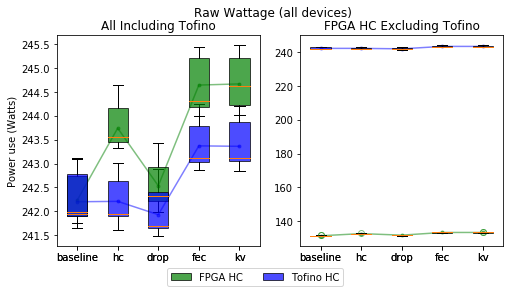

In [29]:
plt.figure(figsize=(8,4))
compare_dev_exp_power(all_devs(), all_devs())
plt.suptitle("Raw Wattage (all devices)");

### Raw wattage of used devices

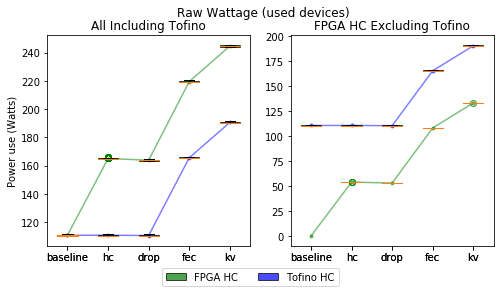

In [20]:
plt.figure(figsize=(8,4))
compare_dev_exp_power(fpga_devs(), tofino_devs())
plt.suptitle("Raw Wattage (used devices)");

### Usage above baseline

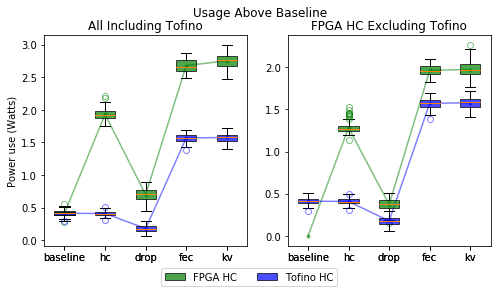

In [21]:
plt.figure(figsize=(8, 4))
compare_dev_exp_power(fpga_devs(), tofino_devs(), sub_baseline=True)
plt.suptitle("Usage Above Baseline");